# Customer Churn Prediction

Churn prediction is the process of identifying customers who are likely to stop using a product or service in the near future. It involves analyzing historical customer behavior, usage patterns, and engagement metrics to predict which customers are at risk of leaving. Churn prediction is valuable because it enables businesses to proactively address customer retention issues by identifying at-risk customers early and taking targeted actions, such as personalized outreach, discounts, or improved service offerings to re-engage them. By reducing churn, companies can improve customer lifetime value (LTV), maintain steady revenue streams, and optimize marketing and customer success strategies, ultimately leading to growth and stability.

## Importing Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('churn_dataset.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

## Preprocessing

Our dataset has the following features:
- customerID          : Unique customer ID
- gender              : Customer's gender
- SeniorCitizen       : 0/1 binary describing whether or not customer is a senior citizen
- Partner             : Yes/No binary describing whether or not customer has a partner
- Dependents          : Yes/No binary describing whether or not customer has dependents
- tenure              : Int describing how long customer has been a customer
- PhoneService        : Yes/No binary describing whether or not customer has phone service through the company
- MultipleLines       : Describes whether or not customer has multiple phone lines (Yes/No/No phone service)
- InternetService     : Describes what, if any, internet service customer has
- OnlineSecurity      : Yes/No binary describing whether or not customer has online security service
- OnlineBackup        : Yes/No binary describing whether or not customer has online backups
- DeviceProtection    : Yes/No binary describing whether or not customer has device protection
- TechSupport         : Yes/No binary describing whether or not customer has
- StreamingTV         : Yes/No binary describing whether or not customer has
- StreamingMovies     : Yes/No binary describing whether or not customer has
- Contract            : Describes customer's payment contract length
- PaperlessBilling    : Yes/No binary describing whether or not customer has
- PaymentMethod       : Describes customer's payment method
- MonthlyCharges      : Float describing customer's monthly price
- TotalCharges        : Describes the total amount customer has paid
- Churn               : Yes/No binary describing whether or not customer churned

customerID is unlikely to have any effect on the prediction, because in real life, a random ID does not influence whether or not a customer churns. We can safely start preprocessing by dropping that column and checking for NaN values.

### NaN values and imputing

In [4]:
# Drop CustomerID
df = df.drop('customerID', axis=1)

In [5]:
# Check for NaN values
null_count = df.isnull().sum()
print(f"Count of null values:\n{null_count}")

Count of null values:
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


TotalCharges has some missing data. We could take the standard approach of mean imputation, but TotalCharges is logically dependent on 'tenure', 'Contract', and 'MonthlyCharges'. Simple mean imputation might provide a less accurate estimate than possible. Let's try a logical heuristic:\
$TotalCharges = MonthlyCharges \times tenure$

In [6]:
# Impute estimated TotalCharges
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] = df['MonthlyCharges'] * df['tenure']

# Verify if there are any missing values left
print("Missing values remaining in TotalCharges:", df['TotalCharges'].isna().sum())

Missing values remaining in TotalCharges: 0


In [7]:
# Split into X and y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
print(X)

[['Female' 0 'Yes' ... 'Electronic check' 29.85 29.85]
 ['Male' 0 'No' ... 'Mailed check' 56.95 1889.5]
 ['Male' 0 'No' ... 'Mailed check' 53.85 108.15]
 ...
 ['Female' 0 'Yes' ... 'Electronic check' 29.6 346.45]
 ['Male' 1 'Yes' ... 'Mailed check' 74.4 306.6]
 ['Male' 0 'No' ... 'Bank transfer (automatic)' 105.65 6844.5]]


### Categorical encoding

A lot of our dataset features are categorical, so we need to encode them.
ColumnTransformer (for binaries): gender, SeniorCitizen, Partner, Dependents, PhoneService, Multiplelines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod
LabelEncoder (for y): Churn

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Encode inputs
features_to_encode = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
featureIdx_to_encode = [df.columns.get_loc(col) for col in features_to_encode if col in df.columns]

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), featureIdx_to_encode)], remainder='passthrough')
X = ct.fit_transform(X)
print(X)

# Encode y
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

[[1.0 0.0 1.0 ... 1 29.85 29.85]
 [0.0 1.0 1.0 ... 34 56.95 1889.5]
 [0.0 1.0 1.0 ... 2 53.85 108.15]
 ...
 [1.0 0.0 1.0 ... 11 29.6 346.45]
 [0.0 1.0 0.0 ... 4 74.4 306.6]
 [0.0 1.0 1.0 ... 66 105.65 6844.5]]
[0 0 1 ... 0 1 0]


### Train test split

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Scaling

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train[:, 43:46] = sc.fit_transform(x_train[:, 43:46])
x_test[:, 43:46] = sc.transform(x_test[:, 43:46])

## Model Training

### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
logistic_classifier = LogisticRegression(random_state=42)
logistic_classifier.fit(x_train, y_train)
logistic_y_pred = logistic_classifier.predict(x_test)

### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
random_forest_classifier = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=42)
random_forest_classifier.fit(x_train, y_train)
random_forest_y_pred = random_forest_classifier.predict(x_test)

### XGBoost

In [13]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42)
xgb_classifier.fit(x_train, y_train)
xgb_y_pred = xgb_classifier.predict(x_test)

### SVM

In [14]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel = 'rbf', random_state = 42)
svm_classifier.fit(x_train, y_train)
svm_y_pred = svm_classifier.predict(x_test)

## Model Accuracy Comparison

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a function to evaluate models
def evaluate_model(model_name, y_true, y_pred) -> dict:
    accuracy = 100 * accuracy_score(y_true, y_pred)
    precision = 100 * precision_score(y_true, y_pred)
    recall = 100 * recall_score(y_true, y_pred)
    f1 = 100 * f1_score(y_true, y_pred)
    
    print(f"\nMetrics for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Evaluate all three models
lr_metrics = evaluate_model("Logistic Regression", y_test, logistic_y_pred)
rf_metrics = evaluate_model("Random Forest", y_test, random_forest_y_pred)
xgb_metrics = evaluate_model("XGBoost Classifier", y_test, xgb_y_pred)
svm_metrics = evaluate_model("SVM Classifier", y_test, svm_y_pred)


Metrics for Logistic Regression:
Accuracy: 82.11%
Precision: 68.62%
Recall: 59.79%
F1 Score: 63.90%

Metrics for Random Forest:
Accuracy: 79.84%
Precision: 66.79%
Recall: 47.45%
F1 Score: 55.49%

Metrics for XGBoost Classifier:
Accuracy: 80.70%
Precision: 67.24%
Recall: 52.82%
F1 Score: 59.16%

Metrics for SVM Classifier:
Accuracy: 81.12%
Precision: 68.90%
Recall: 52.28%
F1 Score: 59.45%


## Visualization

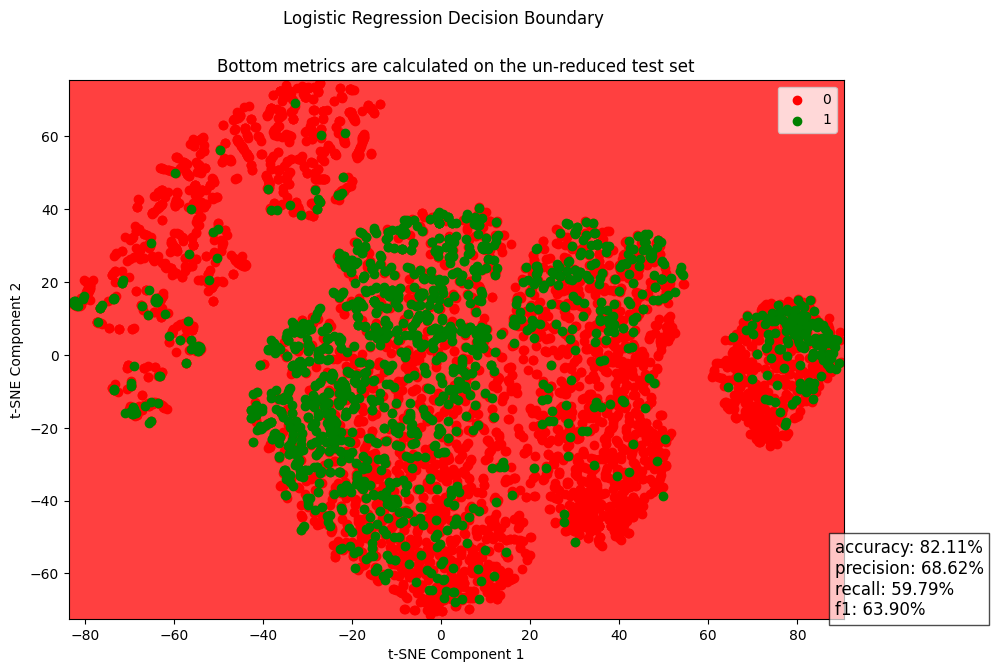

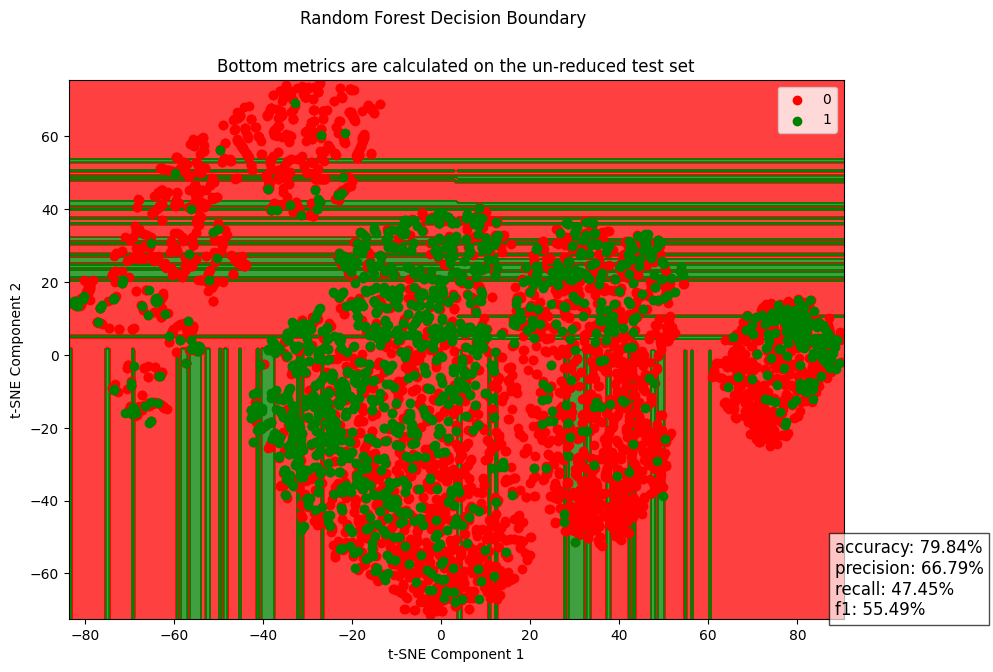

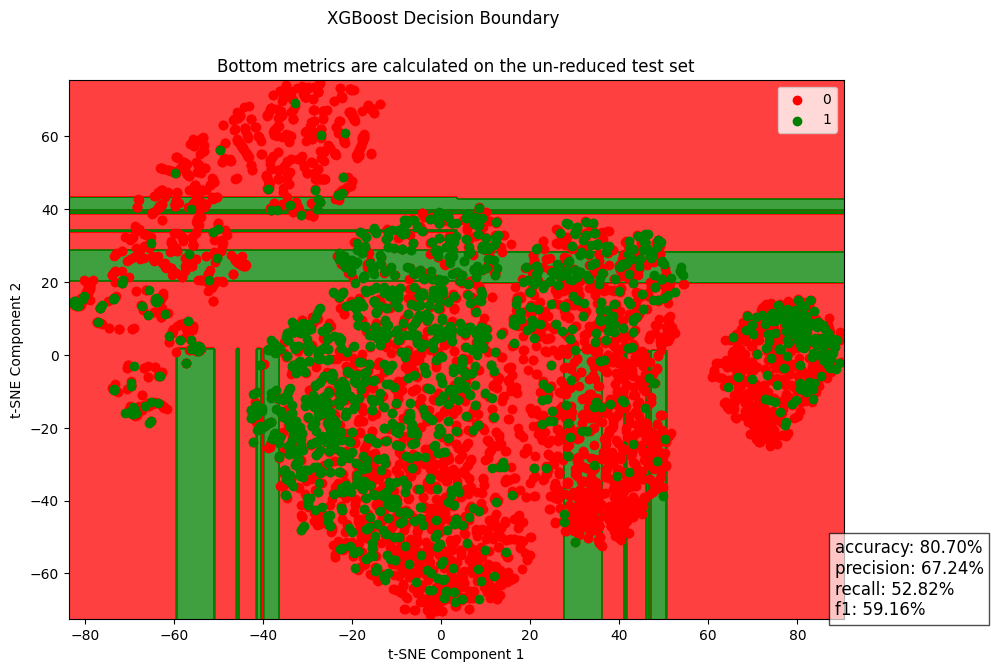

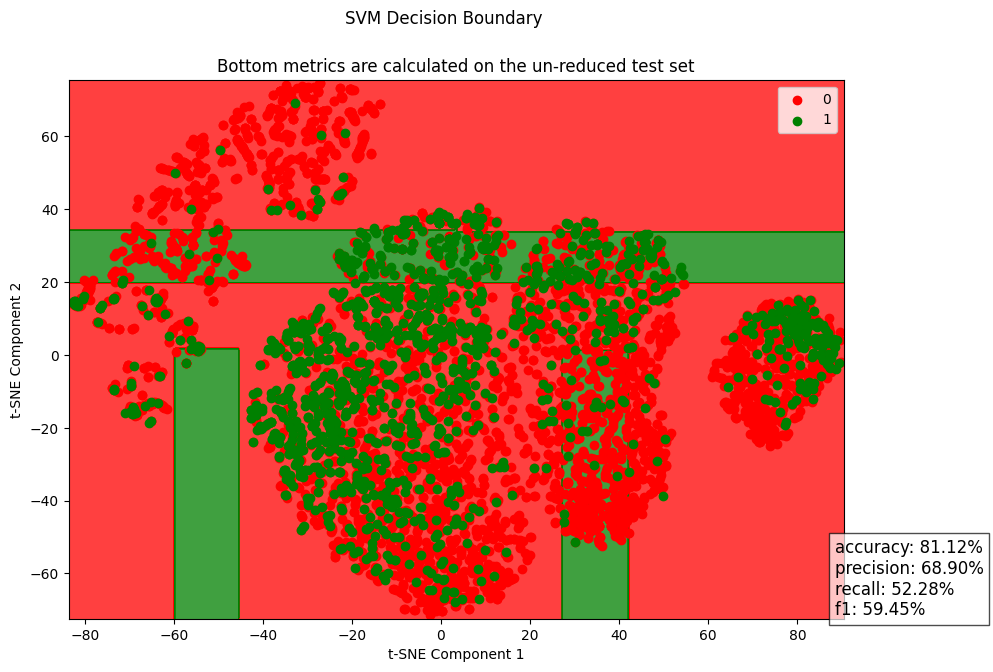

In [16]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import warnings
import copy

# Ignore ListedColormap warnings
warnings.filterwarnings("ignore", category=UserWarning)

def plot_decision_boundary_with_tsne(classifier, X_train, y_train, title, metrics=None):
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    X_train_tsne = tsne.fit_transform(X_train)
    tsne_classifier = copy.deepcopy(classifier)
    tsne_classifier.fit(X_train_tsne, y_train)

    # Generate mesh grid for decision boundary plotting
    X1, X2 = np.meshgrid(np.arange(start=X_train_tsne[:, 0].min() - 1, stop=X_train_tsne[:, 0].max() + 1, step=0.5),
                         np.arange(start=X_train_tsne[:, 1].min() - 1, stop=X_train_tsne[:, 1].max() + 1, step=0.5))
    Z = tsne_classifier.predict(np.array([X1.ravel(), X2.ravel()]).reshape(-1, 2)).reshape(X1.shape)
    plt.figure(figsize=(10, 7))
    plt.contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_train)):
        plt.scatter(X_train_tsne[y_train == j, 0], X_train_tsne[y_train == j, 1],
                    c=ListedColormap(('red', 'green'))(i), label=j)

    # Add metrics as text on the plot
    if metrics:
        metric_text = "\n".join([f"{k}: {v:.2f}%" for k, v in metrics.items()])
        plt.text(X1.max() - 2, X2.min() + 1, metric_text, fontsize=12, 
                 bbox=dict(facecolor='white', alpha=0.7))

    plt.suptitle(title)
    plt.title('Bottom metrics are calculated on the un-reduced test set')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()

# Call the function for each model using t-SNE
plot_decision_boundary_with_tsne(logistic_classifier, x_train, y_train, "Logistic Regression Decision Boundary", lr_metrics)
plot_decision_boundary_with_tsne(random_forest_classifier, x_train, y_train, "Random Forest Decision Boundary", rf_metrics)
plot_decision_boundary_with_tsne(xgb_classifier, x_train, y_train, "XGBoost Decision Boundary", xgb_metrics)
plot_decision_boundary_with_tsne(svm_classifier, x_train, y_train, "SVM Decision Boundary", svm_metrics)

## Conclusion

All of this analysis is great, but it becomes truly valuable when we can use it to predict whether or not a customer is going to churn. We could use our best model (logistic regression) and predict an output based on some real-customer input data. If the model predicts the customer is likely to churn, we could proactively reach out to them, offer a promotion or discount, or get feedback from them. Over time, we would expect these actions to improve churn, thus reducing revenue leakage, maximizing average customer LTV, and minimizing average CAC.

In [17]:
# Example prediction
# Customer details: Male, No SeniorCitizen, Yes Partner, No Dependents, 14 month tenure, Yes PhoneService, No MultipleLines, Fiber optic InternetService, No OnlineSecurity, Yes OnlineBackup, Yes DeviceProtection, Yes TechSupport, Yes StreamingTV, Yes StreamingMovies, Month-to-month Contract, Yes PaperlessBilling, Electronic check PaymentMethod, $60 MonthlyCharges, $840 TotalCharges
example_customer = np.array(["Male", 0, "Yes", "No", 14.00, "Yes", "No", "Fiber optic", "No", "Yes", "Yes", "Yes", "Yes", "Yes", "Month-to-month", "Yes", "Electronic check", 60.00, 840.00], dtype=object).reshape(1, -1)
# Encode customer details
example_featureIdx_to_encode = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
example_customer = ct.transform(example_customer)
# Scale customer details
example_customer[:, 43:46] = sc.transform(example_customer[:, 43:46])
# Predict
example_prediction = logistic_classifier.predict(example_customer)
print(f"Churn prediction for the example customer: {'Customer is predicted to churn' if example_prediction[0] == 1 else 'Customer is not predicted to churn'}")

Churn prediction for the example customer: Churn
